In [2]:
# RUN THIS CELL FIRST

import matplotlib.pyplot as plt
import numpy as np
import astropy.coordinates as coords
import astropy.time as time
import astropy.units as u



In [10]:
star1 = 'Dubhe'
star2 = 'Merak'
star3 = 'Deneb'
star4 = 'Vega'
star5 = 'Altair'
star6 = 'Fomalhaut'
star7 = 'Enif'
star8 = 'Scheat'

polaris = 'Polaris'

In [37]:
def alt_az_generator(star, night):
    lat = 37.873175 # deg
    lon = -122.257063
    alt = 120. # m

    if night == 1:
        jd = np.linspace(2460965.291667,2460965.458333,24)
    elif night == 2:
        jd = np.linspace(2460987.291667,2460987.458333,24)

    t = time.Time(jd,format='jd')
    lsts = t.sidereal_time('apparent',longitude=lon*u.deg).radian
    star_coord = coords.SkyCoord.from_name(star)
    ra_star, dec_star = star_coord.ra.deg, star_coord.dec.deg

    location = coords.EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m)
    altaz = coords.AltAz(obstime = t,location=location)
    vega_altaz = star_coord.transform_to(altaz)
    alt_deg, az_deg = vega_altaz.alt.deg, vega_altaz.az.deg

    return alt_deg, az_deg, lsts

In [39]:
# Imput your stars into the functions below and choose whether it is for night 1 or night 2 observations

Observation = 2 # Change to 2 for night 2 data

alt_1, az_1, lst1 = alt_az_generator(polaris, Observation)
alt_2, az_2, lst2 = alt_az_generator(star1, Observation)
alt_3, az_3, lst3 = alt_az_generator(star5, Observation)


In [40]:
def r_theta(alt, az):
    """Convert alt-az coordinates to r-theta coordinates for polar plotting."""
    r = np.array(alt)
    theta = np.deg2rad(np.array(az))
    return theta, r

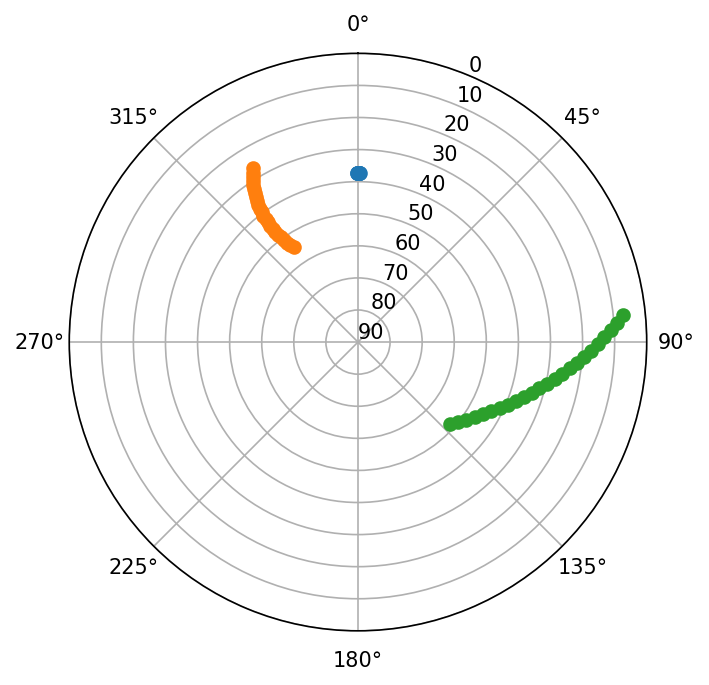

In [41]:
fig = plt.figure(figsize=(6, 5), dpi=150)
ax = fig.add_subplot(111, polar=True)

coords_1 = r_theta(alt_1, az_1)
coords_2 = r_theta(alt_2, az_2)
coords_3 = r_theta(alt_3, az_3)
# coords_4 = r_theta(alt_4, az_4)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

ax.plot(coords_1[0], coords_1[1], marker='o')
ax.plot(coords_2[0], coords_2[1], marker='o')
ax.plot(coords_3[0], coords_3[1], marker='o')
# ax.plot(coords_4[0], coords_4[1], marker='o')


ax.set_rlim(90, 0)
plt.show()

## Converting between altitude and azimuth to hour angle and declination
### The rotation matrix in charge of this transformation only depends on the latitude of your location.

You should know the coordinates of Campbell Hall: \
latitude: 37.87 N\
longitude: 122.25 W

In [26]:
# This function converts from hour angle and declination to altitude and azimuth using a rotation matrix dependent on latitude
# Feel free to save this function for future use! (If you are an astronomy student, you will likely need to use it again)

def ha2top(lat):
    "(ha,dec) to (alt,az)"
    rot_mat = np.array([
        [-np.sin(lat), 0, np.cos(lat)],
        [0          , -1,           0],
        [ np.cos(lat), 0, np.sin(lat)],
    ])
    return rot_mat

# This function creates a rotation matrix to convert from right ascension and declination to hour angle and declination.

def ra2ha(LST):
    "(ra,dec) to (ha,dec)"
    ones = np.ones_like(LST)
    rot_mat = np.array([
        [np.cos(LST), np.sin(LST), 0*ones],
        [-np.sin(LST), np.cos(LST), 0*ones],
        [ 0*ones, 0*ones, 1*ones],
    ])
    return rot_mat



# This function creates a vector of topological coordinates for a single alt/az point.
# A vector is a mathematical object that represents a quantity with both magnitude and direction, 
# often written as a list of numbers (its components) that describe how far it points along each 
# coordinate axis in space. (You don't need to worry about this)

def vec_top(alt, az):
    v = np.array([np.cos(alt)*np.cos(az),
                    np.cos(alt)*np.sin(az),
                    np.sin(alt)])
    return v

# Make sure to run this cell before the next one

In [27]:
# Since we are going to want to compute the Ha and Dec for each star, we will wrap this process in a function for repeated use.

def Ha_Dec(alt, az, lat):
    R = ha2top(np.deg2rad(lat))
    vtop = vec_top(np.deg2rad(alt), np.deg2rad(az))
    vha = R.T @ vtop
    return np.arctan2(vha[1], vha[0]), np.arcsin(vha[2]) 
    

In [42]:
LAT = 37.873175 # deg

star_1_Ha, star_1_dec = Ha_Dec(alt_1, az_1, LAT)
star_2_Ha, star_2_dec = Ha_Dec(alt_2, az_2, LAT)
star_3_Ha, star_3_dec = Ha_Dec(alt_3, az_3, LAT)
# star_4_Ha, star_4_dec = Ha_Dec(alt_4, az_4, LAT)

## Converting between hour angle and declination to right ascension and declination
### The rotation matrix in charge of this transformation only depends on the local sidereal time of your observations.

In [29]:
# Lets put this in a function too

def Ra_Dec(alt, az, lst, lat):
    R1 = ha2top(np.deg2rad(lat))
    R2 = ra2ha(lst)
    vtop = vec_top(np.deg2rad(alt), np.deg2rad(az))
    vha = R1.T @ vtop
    ra_dec = np.einsum('jik,ik->jk',R2,vha)
    return np.arctan2(ra_dec[1], ra_dec[0]), np.arcsin(ra_dec[2]) 

In [43]:
star_1_Ra, star_1_dec = Ra_Dec(alt_1, az_1, lst1, LAT)
star_2_Ra, star_2_dec = Ra_Dec(alt_2, az_2, lst2, LAT)
star_3_Ra, star_3_dec = Ra_Dec(alt_3, az_3, lst3, LAT)
#star_4_Ra, star_4_dec = Ra_Dec(alt_4, az_4, lst4, LAT)


# Plots plots plots!

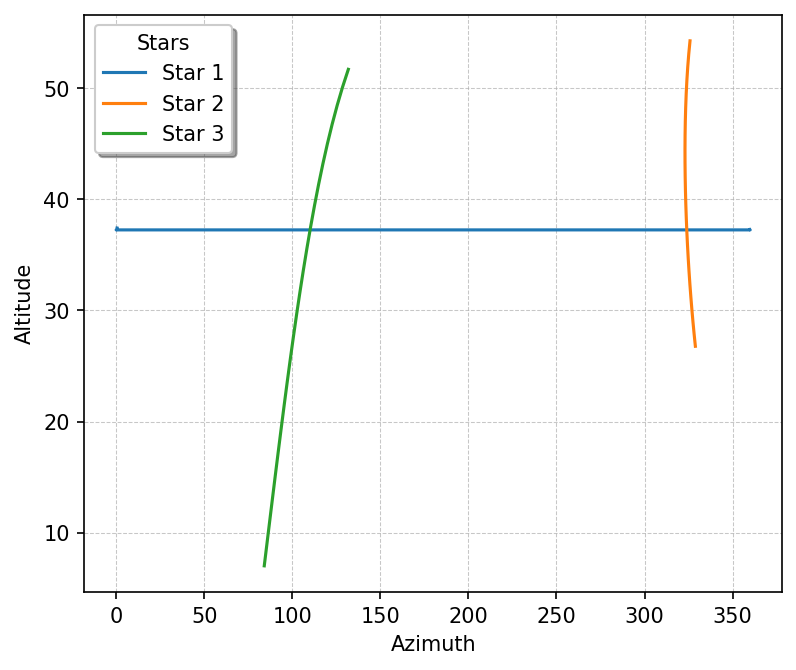

In [44]:
fig = plt.figure(figsize=(6, 5), dpi=150)
gs = fig.add_gridspec(1, hspace=0)
ax = fig.add_subplot(gs[:])

ax.plot(az_1, alt_1, label='Star 1')
ax.plot(az_2, alt_2, label='Star 2')
ax.plot(az_3, alt_3, label='Star 3')
# ax.plot(alt_4, az_4, label='Star 4')

ax.set_xlabel('Azimuth', fontsize=10)
ax.set_ylabel('Altitude', fontsize=10)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=1)

ax.legend(title='Stars', frameon=True, shadow=True, loc="best")


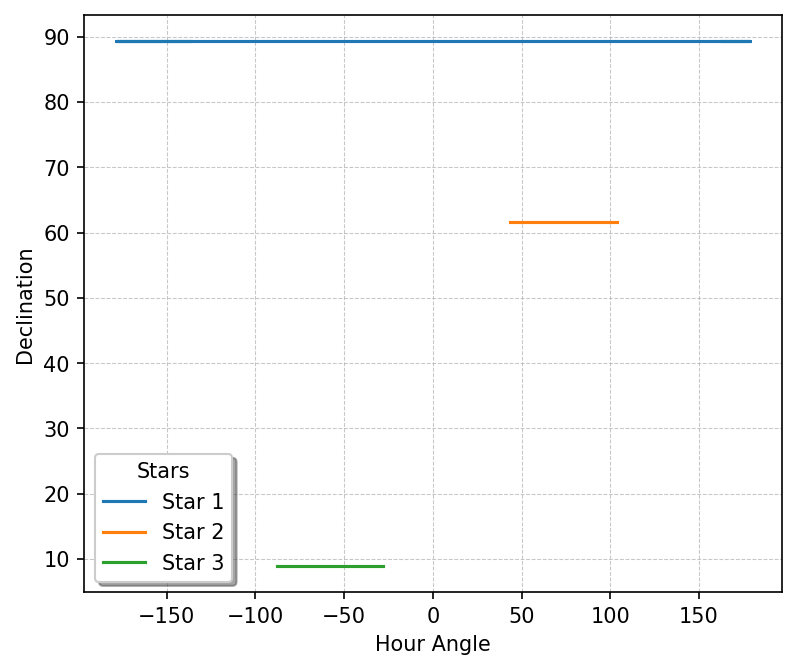

In [45]:
fig = plt.figure(figsize=(6, 5), dpi=150)
gs = fig.add_gridspec(1, hspace=0)
ax = fig.add_subplot(gs[:])

ax.plot(np.rad2deg(star_1_Ha), np.rad2deg(star_1_dec), label='Star 1')
ax.plot(np.rad2deg(star_2_Ha), np.rad2deg(star_2_dec), label='Star 2')
ax.plot(np.rad2deg(star_3_Ha), np.rad2deg(star_3_dec), label='Star 3')
# ax.plot(np.rad2deg(star_4_Ha), np.rad2deg(star_4_dec), label='Star 4')

ax.set_xlabel('Hour Angle', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=1)

ax.legend(title='Stars', frameon=True, shadow=True, loc="best")


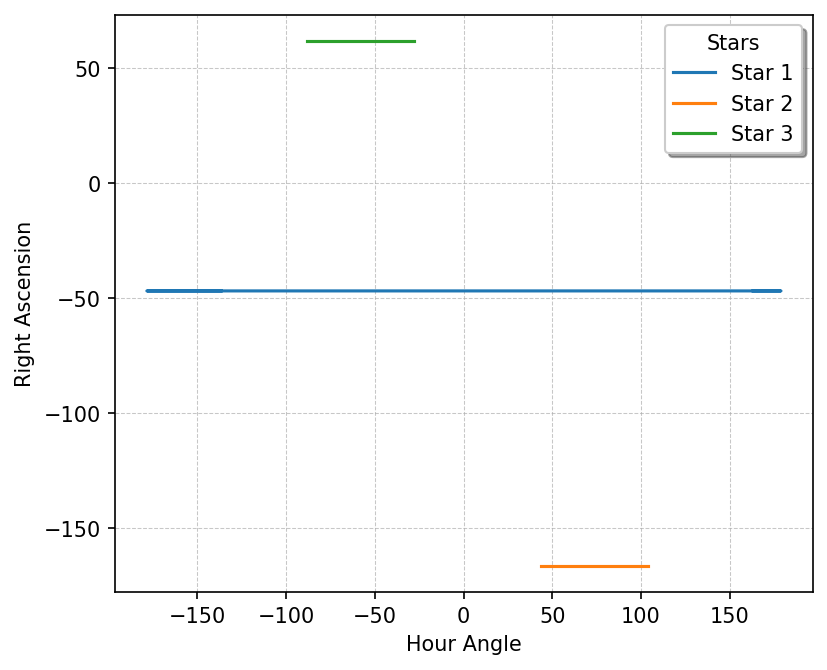

In [46]:
fig = plt.figure(figsize=(6, 5), dpi=150)
gs = fig.add_gridspec(1, hspace=0)
ax = fig.add_subplot(gs[:])

ax.plot(np.rad2deg(star_1_Ha), np.rad2deg(star_1_Ra), label='Star 1')
ax.plot(np.rad2deg(star_2_Ha), np.rad2deg(star_2_Ra), label='Star 2')
ax.plot(np.rad2deg(star_3_Ha), np.rad2deg(star_3_Ra), label='Star 3')
# ax.plot(np.rad2deg(star_4_Ha), np.rad2deg(star_4_Ra), label='Star 4')

ax.set_xlabel('Hour Angle', fontsize=10)
ax.set_ylabel('Right Ascension', fontsize=10)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=1)

ax.legend(title='Stars', frameon=True, shadow=True, loc="best")

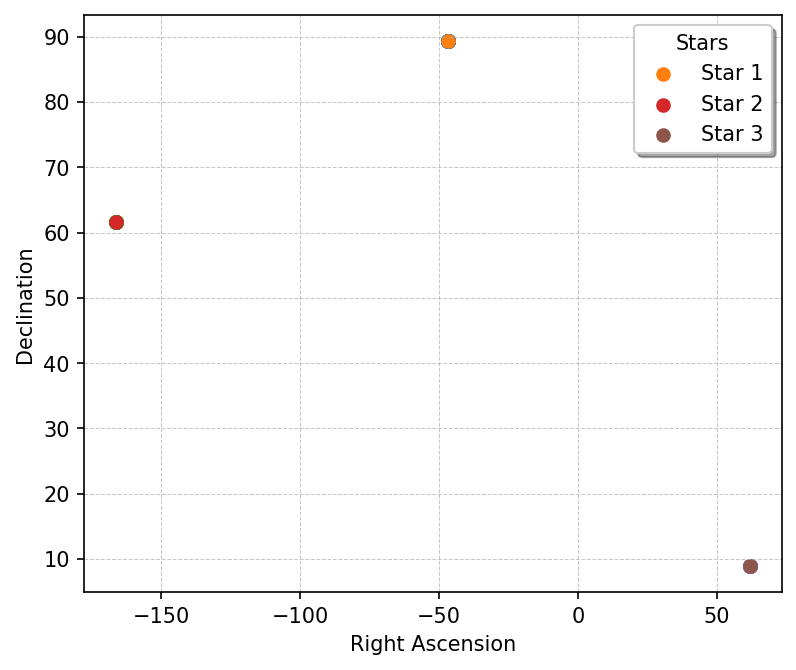

In [47]:
fig = plt.figure(figsize=(6, 5), dpi=150)
gs = fig.add_gridspec(1, hspace=0)
ax = fig.add_subplot(gs[:])

ax.scatter(np.rad2deg(star_1_Ra), np.rad2deg(star_1_dec))
ax.scatter(np.rad2deg(star_1_Ra.mean()), np.rad2deg(star_1_dec.mean()), label='Star 1')

ax.scatter(np.rad2deg(star_2_Ra),  np.rad2deg(star_2_dec))
ax.scatter(np.rad2deg(star_2_Ra.mean()), np.rad2deg(star_2_dec.mean()), label='Star 2')

ax.scatter(np.rad2deg(star_3_Ra), np.rad2deg(star_3_dec))
ax.scatter(np.rad2deg(star_3_Ra.mean()), np.rad2deg(star_3_dec.mean()), label='Star 3')

# ax.plot(np.rad2deg(star_4_Ra), np.rad2deg(star_4_dec))
# ax.plot(np.rad2deg(star_4_Ra.mean()), np.rad2deg(star_4_dec.mean()), label='Star 4')

ax.set_xlabel('Right Ascension', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=1)

ax.legend(title='Stars', frameon=True, shadow=True, loc="best")


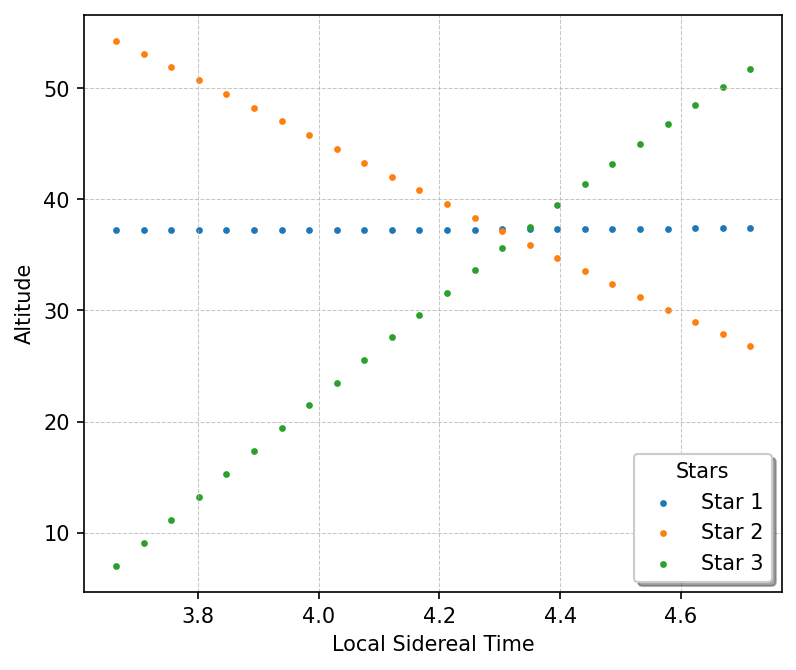

In [48]:
fig = plt.figure(figsize=(6, 5), dpi=150)
gs = fig.add_gridspec(1, hspace=0)
ax = fig.add_subplot(gs[:])

ax.scatter(lst1, alt_1, s=5, label='Star 1')
ax.scatter(lst2, alt_2, s=5, label='Star 2')
ax.scatter(lst3, alt_3, s=5, label='Star 3')
# ax.scatter(LST_rad, alt_4, s=5, label='Star 4')


ax.set_xlabel('Local Sidereal Time', fontsize=10)
ax.set_ylabel('Altitude', fontsize=10)

ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=1)

ax.legend(title='Stars', frameon=True, shadow=True, loc="best")
